#About Dataset


link  https://www.kaggle.com/datasets/mdnafeesimtiaz/ct-scan-images-of-lung-cancer/data



This dataset contains CT scan images for lung cancer detection and classification. It includes images of five different categories: benign (non-cancerous, or non-malignant, growth in the lung or airways), normal (non-cancerous), adenocarcinoma, large cell carcinoma, squamous cell carcinoma lung tissue.

## Imports

In [ ]:
import kagglehub
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data

In [ ]:
# Download latest version
path = kagglehub.dataset_download("mdnafeesimtiaz/ct-scan-images-of-lung-cancer")

print("Path to dataset files:", path)

100%|██████████| 205M/205M [00:10<00:00, 20.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mdnafeesimtiaz/ct-scan-images-of-lung-cancer/versions/1


In [ ]:
print(os.listdir(path))

['Lung Cancer Dataset']


In [ ]:
data_dir = os.path.join(path, 'Lung Cancer Dataset')

In [ ]:
img_height = 224 # Changed to match EfficientNetB0 input size
img_width = 224 # Changed to match EfficientNetB0 input size

# Define the batch size
batch_size = 32

# Load the images, resize, and split into training and validation sets
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1535 files belonging to 5 classes.
Using 1228 files for training.
Found 1535 files belonging to 5 classes.
Using 307 files for validation.


## Basic model

In [ ]:
num_classes = 5

model = keras.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 289ms/step - accuracy: 0.4212 - loss: 2.0730 - val_accuracy: 0.6971 - val_loss: 0.8106
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6693 - loss: 0.8091 - val_accuracy: 0.7655 - val_loss: 0.6030
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7422 - loss: 0.5959 - val_accuracy: 0.8404 - val_loss: 0.4070
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8007 - loss: 0.4871 - val_accuracy: 0.8730 - val_loss: 0.3463
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8750 - loss: 0.3513 - val_accuracy: 0.9153 - val_loss: 0.2236
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9163 - loss: 0.2054 - val_accuracy: 0.9186 - val_loss: 0.1854
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9404 - loss: 0.1911 - val_accuracy: 0.9446 - val_loss: 0.1537
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9374 - loss: 0.1626 - val_accuracy: 0.9381 -

## Basic Model result

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9298 - loss: 0.1894
Validation Loss: 0.15903805196285248
Validation Accuracy: 0.9315961003303528


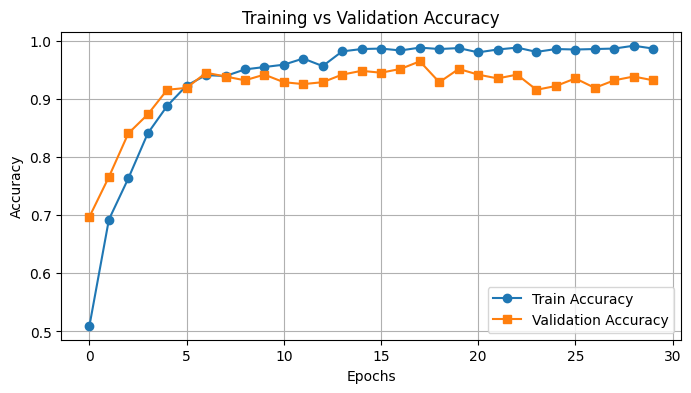

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


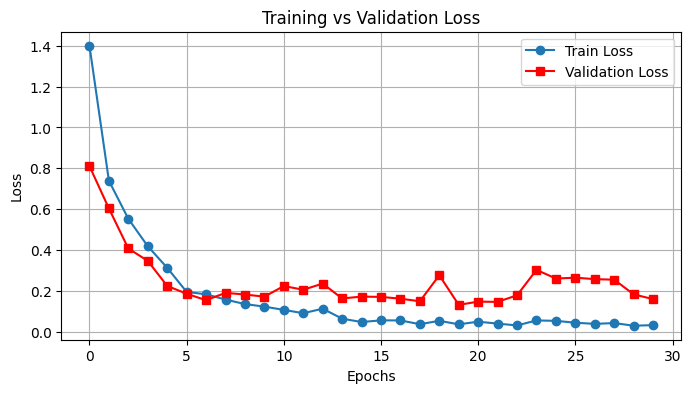

In [ ]:
# Loss Plot
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Deploying the Model with Flask

To deploy our trained Keras model, we will use Flask, a lightweight Python web framework. This will allow us to create a web service that can receive requests, make predictions using our model, and return the results.

### Save the Trained Model

Before we can deploy, we need to save the trained Keras model so that our Flask application can load it.

In [ ]:
model.save('lung_cancer_model.h5')
print("Model saved as 'lung_cancer_model.h5'")

Model saved as 'lung_cancer_model.h5'
